# 💻 Configuración del entorno (ver readme)

In [ ]:
# Esto es para gastar todos los recursos de google-colab y que te den una maquina mas potente en la version gratuita
# while True: sum(i*i for i in iter(int, 1))

In [1]:
# permisos para acceder a googleDrive
from google.colab import drive
import os
drive.mount('/content/drive')

drive_folder = 'drive/MyDrive/TESIS/'

# Definición de la base de datos
tags_file = drive_folder + 'db/data.csv'
data_folder = drive_folder + 'db/data/'
image_folder = drive_folder + 'db/images/cow/'
shape_folder = drive_folder + 'db/images/shape/'
output_folder = drive_folder + 'db/output/'
test_output_folder = drive_folder + 'db/output-test/'

# si no da error es que se cargaron bien
files = os.listdir(image_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  # 🤖 Configuración del modelo


In [2]:
import os
import torch
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
import torchvision.models.segmentation as segmentation_models
available_models = dir(segmentation_models)
available_models = ["deeplabv3","deeplabv3_mobilenet_v3_large","deeplabv3_resnet101","deeplabv3_resnet50","fcn","fcn_resnet101","fcn_resnet50","lraspp","lraspp_mobilenet_v3_large"]

In [4]:
image_folder = image_folder  # Directorio de entrada con imágenes
pretrained = True  # Utilizar pesos preentrenados del modelo (!parametro DEPRECADO)
resize_input = 256  # Tamaño de redimensionamiento de la entrada

crop_size = 224  # Tamaño de recorte centrado
mean = [0.485, 0.456, 0.406]  # Media para la normalización
std = [0.229, 0.224, 0.225]  # Desviación estándar para la normalización

In [6]:
model_name = "fcn_resnet50"  # Nombre del modelo a utilizar

Modelos de segmentación disponibles dentro de `torchvision`:

  - DeepLabV3
  - DeepLabV3_MobileNet_V3_Large_Weights
  - DeepLabV3_ResNet101_Weights
  - DeepLabV3_ResNet50_Weights
  - FCN
  - FCN_ResNet101_Weights
  - FCN_ResNet50_Weights
  - LRASPP
  - LRASPP_MobileNet_V3_Large_Weights
  - deeplabv3
  - deeplabv3_mobilenet_v3_large
  - deeplabv3_resnet101
  - deeplabv3_resnet50
  - fcn
  - fcn_resnet101
  - fcn_resnet50
  - lraspp
  - lraspp_mobilenet_v3_large




In [7]:
# Cargar modelo
model_fn = getattr(models.segmentation, model_name)
model = model_fn(pretrained=pretrained)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 123MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [8]:
# Transformaciones necesarias para la entrada del modelo
transform = T.Compose([
    T.Resize(resize_input),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

# 🏃‍♀️‍➡️ Ejecución del modelo

## 📂 Funciones de utilidad

In [9]:
def save_image(extracted_image, image_name, test=False):
    """
    Saves the extracted image to the appropriate output folder.

    Args:
        extracted_image (PIL.Image.Image): The image with the region of interest extracted.
        image_name (str): The name to save the image as.
        test (bool): Whether to save in the test output folder or the regular output folder.
    """
    output = test_output_folder if test else output_folder
    # Crear carpeta para el output si no existe
    if not os.path.exists(output):
        os.makedirs(output)

    # guardar imagen
    output_path = os.path.join(output, image_name)
    extracted_image.save(output_path)

def show_image(original_image, extracted_image, accuracy_percentage=""):
    """
    Displays the original and extracted images side by side.

    Args:
        original_image (PIL.Image.Image): The original input image.
        extracted_image (PIL.Image.Image): The extracted region of interest from the image.
        accuracy_percentage (str): The accuracy percentage to display in the title.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(extracted_image)
    ax[1].set_title(f'Extracted Region ({round(accuracy_percentage, 2)}%)')
    ax[1].axis('off')

    plt.show()

def export_predictions_to_csv(results, filename='predictions.csv', output_file=""):
    """
    Exports the model prediction results to a CSV file.

    Args:
        results (list of tuples): A list of tuples where each tuple contains the image name, accuracy percentage, and mean distance.
        filename (str): The name of the CSV file to save the results to.
    """
    import csv

    # Crear carpeta para el output si no existe
    if not os.path.exists((output_folder + output_file)):
        os.makedirs((output_folder + output_file))

    # Abrir el archivo CSV para escribir
    output = output_folder + output_file + "/" + filename
    with open(output, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Escribir el encabezado
        writer.writerow(['Image Name', 'Prediction Accuracy (%)', 'Mean Distance'])

        # Escribir las filas de datos
        for result in results:
            writer.writerow(result)

## 📂 Funciones de segmentación, máscara y preprocesado

In [10]:
def segment_image(image):
    """
    Segments the input image using the predefined model.

    Args:
        image (PIL.Image.Image): The input image to be segmented.

    Returns:
        torch.Tensor: The segmentation mask of the image.
    """
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_image)['out']
    output_predictions = output.argmax(1)[0]
    return output_predictions

def extract_region(image, mask):
    """
    Extracts the region of interest from the image based on the segmentation mask.

    Args:
        image (PIL.Image.Image): The input image from which the region will be extracted.
        mask (torch.Tensor): The segmentation mask to determine the region of interest.

    Returns:
        PIL.Image.Image: The image with the region of interest extracted.
    """

    # Obtener las dimensiones originales de la imagen
    original_size = image.size

    # Redimensionar la máscara para que coincida con las dimensiones originales de la imagen
    mask_resized = mask.byte().cpu().numpy()
    mask_resized = Image.fromarray(mask_resized).resize(original_size, resample=Image.NEAREST)
    mask_resized = np.array(mask_resized)

    # Convertir la imagen y la máscara a numpy arrays
    image_np = np.array(image)

    # Multiplicar la imagen por la máscara para extraer la región de interés
    extracted_image = image_np * np.expand_dims(mask_resized, axis=2)

    # Convertir el resultado de vuelta a un objeto de imagen y devolverlo
    return Image.fromarray(extracted_image.astype(np.uint8))

In [11]:
def preprocess_image(image_name):
    """
    Preprocesses an image by segmenting it and extracting the region of interest.

    Args:
        image_name (str): The name of the image file to preprocess.

    Returns:
        tuple: A tuple containing the original image (PIL.Image.Image) and the extracted image (PIL.Image.Image).
    """
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(image_folder, image_name)
        original_image = Image.open(image_path).convert("RGB")

        # Segmentar la imagen
        mask = segment_image(original_image)

        # Extraer la región de interés (vaca en este caso)
        extracted_image = extract_region(original_image, mask)

        return original_image, extracted_image

## 📂 Funciones de evaluación

In [12]:
import pandas as pd

def read_points(point_name):
    """
    Reads the anatomical points from a file.

    Args:
        point_name (str): The name of the file containing the anatomical points.

    Returns:
        list: A list of lines containing anatomical points.
    """
    point_path = os.path.join(data_folder, point_name)
    with open(point_path, 'r') as f:
        points = f.readlines()
        return points

data_df = pd.read_csv(tags_file)
data_df.head()

,IMAGE,SHAPE,POINT,BCS1,BCS2
0,71_4_10_20_158_cow.jpg,71_4_10_20_158_shape.png,71_4_10_20_158_Anatomical_Points_BCS1_3_BCS2_3...,3.00,3.00
1,700_4_11_10_298_cow.jpg,700_4_11_10_298_shape.png,700_4_11_10_298_Anatomical_Points_BCS1_3.25_BC...,3.25,3.50
2,700_4_11_10_300_cow.jpg,700_4_11_10_300_shape.png,700_4_11_10_300_Anatomical_Points_BCS1_3.25_BC...,3.25,3.50
3,128_4_4_10_132_cow.jpg,128_4_4_10_132_shape.png,128_4_4_10_132_Anatomical_Points_BCS1_4.25_BCS...,4.25,4.25
4,71_4_10_20_156_cow.jpg,71_4_10_20_156_shape.png,71_4_10_20_156_Anatomical_Points_BCS1_3_BCS2_3...,3.00,3.00


In [13]:
import torch.nn.functional as F
from scipy import ndimage

def get_centroids(mask):
    """
    Calculates the centroids of the segmented regions in the mask.

    Args:
        mask (torch.Tensor): The segmentation mask.

    Returns:
        list: A list of tuples representing the centroids of the segmented regions.
    """
    mask_np = np.array(mask)
    labels, num_labels = ndimage.label(mask_np)
    centroids = ndimage.center_of_mass(mask_np, labels, np.arange(1, num_labels + 1))
    return centroids


def calculate_accuracy_percentage(mean_distance, image_size):
    """
    Calculates the accuracy percentage based on the mean distance and image size.

    Args:
        mean_distance (float): The mean distance between the real and predicted points.
        image_size (tuple): The size of the image (width, height).

    Returns:
        float: The accuracy percentage.
    """
    max_distance = max(image_size)
    accuracy = max(0, 1 - (mean_distance / max_distance)) * 100
    return accuracy


In [14]:
def evaluate_prediction(image_name, point_name, model, image_folder, data_folder):
    """
    Evaluates the prediction accuracy for a given image and its associated anatomical points.

    Args:
        image_name (str): The name of the image file.
        point_name (str): The name of the file containing the anatomical points.
        model (torch.nn.Module): The segmentation model to use for prediction.
        image_folder (str): The directory containing the images.
        data_folder (str): The directory containing the anatomical points files.

    Returns:
        tuple: A tuple containing the mean distance (float) and accuracy percentage (float).
    """

    # Cargar la imagen
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path).convert("RGB")

    # Segmentar la imagen
    mask = segment_image(image)

    # Leer los puntos anatómicos reales desde el archivo correspondiente
    point_path = os.path.join(data_folder, point_name)
    with open(point_path, 'r') as f:
        points = [list(map(float, line.split())) for line in f]

    # Obtener los puntos anatómicos predichos (centroides de las regiones segmentadas)
    predicted_points = get_centroids(mask)

    # Calcular la distancia euclidiana promedio entre los puntos reales y los predichos
    distances = []
    for real_point in points:
        real_point = np.array(real_point)
        min_distance = float('inf')
        for pred_point in predicted_points:
            pred_point = np.array(pred_point)
            distance = np.linalg.norm(real_point - pred_point)
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)

    mean_distance = np.mean(distances)

    # Calcular el porcentaje de precisión
    accuracy_percentage = calculate_accuracy_percentage(mean_distance, image.size)
    return mean_distance, accuracy_percentage

## 🚩 Pre-procesamiento y evaluación de resultados

In [15]:
def evaluate_all_images(data_df, image_folder, data_folder, model, export_output="", show_image=False):
    """
    Evaluates the segmentation predictions for all images listed in the dataframe.

    Args:
        data_df (pandas.DataFrame): The dataframe containing image and point file names.
        image_folder (str): The directory containing the images.
        data_folder (str): The directory containing the anatomical points files.
        model (torch.nn.Module): The segmentation model to use for predictions.
        export_output (str): The directory to save the extracted images.
        show_image (bool): Whether to display the images or not.

    Returns:
        list: A list of tuples where each tuple contains the image name, accuracy percentage, and mean distance.
    """

    results = []
    for idx, row in data_df.iterrows():
        image_name = row['IMAGE']
        shape_name = row['SHAPE']
        point_name = row['POINT']

        mean_distance, accuracy_percentage = evaluate_prediction(image_name, point_name, model, image_folder, data_folder)
        results.append((image_name, accuracy_percentage, mean_distance))

        if show_image or export_output != "":
          original_image, extracted_image = preprocess_image(image_name)

        if show_image:
          # Mostrar el resultado
          show_image(original_image, extracted_image, accuracy_percentage)

        if export_output != "":
          # Guardar el resultado en el directorio de salida
          save_image(extracted_image, f"{export_output}/{image_name}")

    if export_output != "":
        export_predictions_to_csv(results, filename='predictions.csv', output_file=export_output)

    return results


def evaluate_random_image(data_df, image_folder, data_folder, model, num_samples=1, export_output="", show_image=False):
    """
    Evaluates a random sample of images from the dataframe.

    Args:
        data_df (pandas.DataFrame): The dataframe containing image and point file names.
        image_folder (str): The directory containing the images.
        data_folder (str): The directory containing the anatomical points files.
        model (torch.nn.Module): The segmentation model to use for predictions.
        num_samples (int): The number of random samples to evaluate.
        export_output (str): The directory to save the extracted images.
        show_image (bool): Whether to display the images or not.

    Returns:
        list: A list of tuples where each tuple contains the image name, accuracy percentage, and mean distance.
    """
    if num_samples < 1 or num_samples > len(data_df):
        raise ValueError("num_samples debe estar entre 1 y el número total de filas en data_df")

    import random
    random_rows = data_df.sample(n=num_samples)

    results = evaluate_all_images(random_rows, image_folder, data_folder, model, export_output, show_image)
    return results

In [16]:
num_samples = 1 # Número random de samples a evaluar
export_output = "" # Directorio donde extraer las imagenes segmentadas (de ser "" no se extraerar)
show_image = False # Mostrar la imagen segementada+original para comparación visual

In [17]:
# Evaluación de prueba (con una muestra random)
results = evaluate_random_image(data_df, image_folder, data_folder, model, num_samples, export_output, show_image)

In [19]:
# Evaluar todas las imágenes
results = evaluate_all_images(data_df, image_folder, data_folder, model, export_output, show_image)

# 📈 Gráficos de resultados

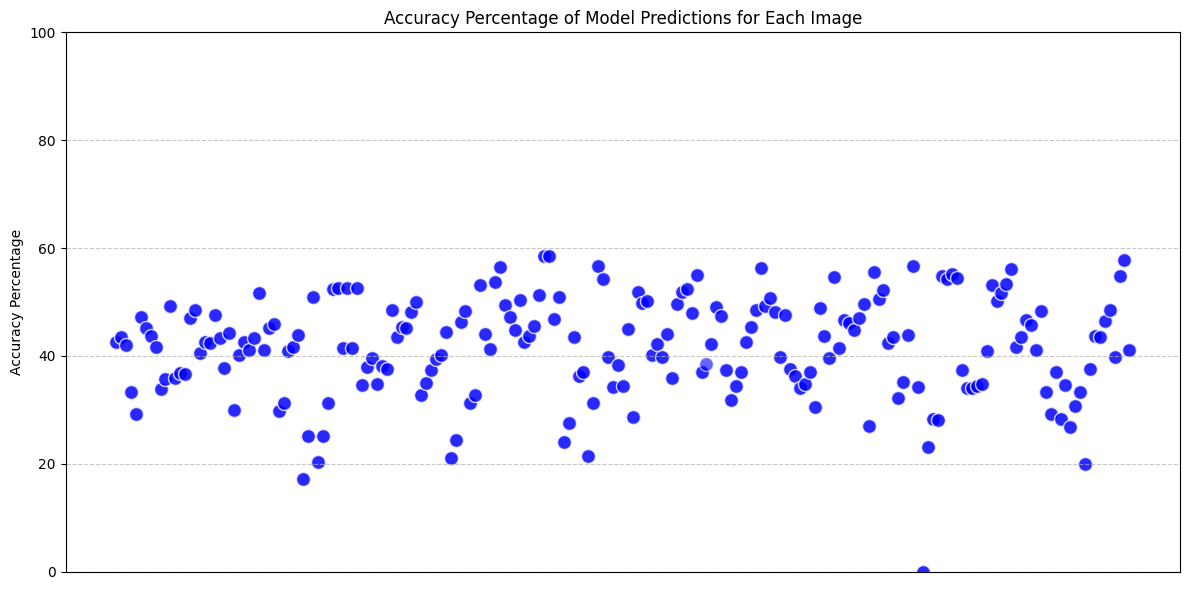

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [20]:
def plot_accuracy_scatter(results, show=True):
    """
    Plots a scatter diagram of the accuracy percentages for each image.

    Args:
        results (list of tuples): A list of tuples where each tuple contains the image name and accuracy percentage.
    """
    results.sort(key=lambda x: x[0])

    # Separar los nombres de las imágenes y los porcentajes de precisión
    image_names = [result[0] for result in results]
    accuracies = [result[1] for result in results]

    # Crear un diagrama de dispersión
    plt.figure(figsize=(12, 6))
    plt.scatter(image_names, accuracies, color='blue', alpha=0.6, edgecolors='w', s=100)
    plt.xticks([])  # Eliminar las etiquetas del eje x
    plt.ylabel('Accuracy Percentage')
    plt.title('Accuracy Percentage of Model Predictions for Each Image')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if show:
      plt.show()
    return plt

plot_accuracy_scatter(results)

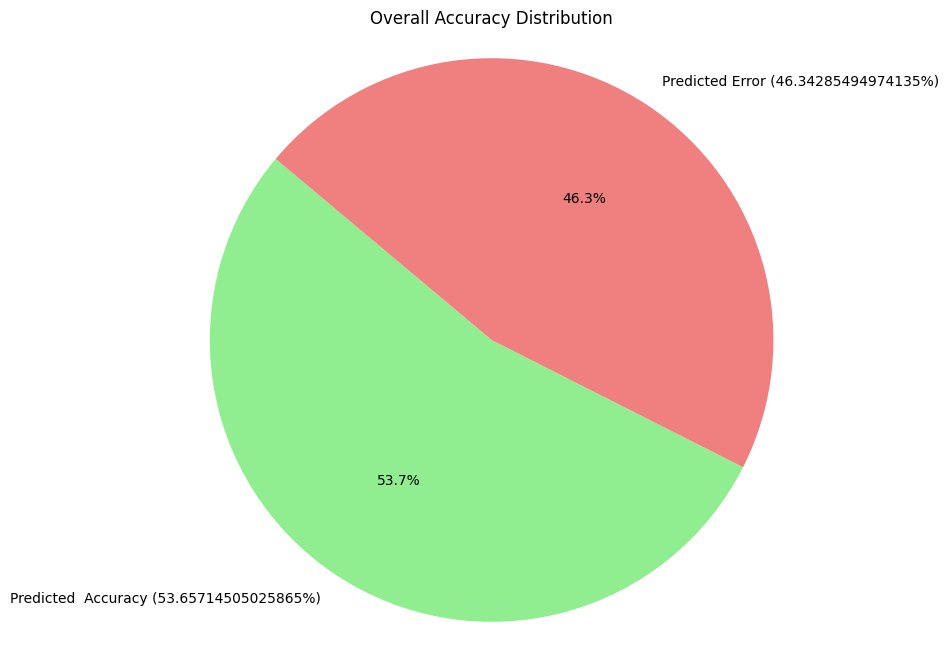

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [18]:
def plot_accuracy_pie(results, show=True):
    """
    Plots a pie chart showing the overall distribution of accuracy.

    Args:
        results (list of tuples): A list of tuples where each tuple contains the image name and accuracy percentage.
    """
    results.sort(key=lambda x: x[0])
    accuracies = [result[1] for result in results]

    # Calcular el promedio de las precisiones
    good_average_accuracy = sum(accuracies) / len(accuracies)
    bad_average_accuracy = 100 - good_average_accuracy

    labels = ['Predicted  Accuracy ({}%)'.format(good_average_accuracy), 'Predicted Error ({}%)'.format(bad_average_accuracy)]
    sizes = [good_average_accuracy, bad_average_accuracy]
    colors = ['lightgreen', 'lightcoral']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Overall Accuracy Distribution')
    if show:
      plt.show()
    return plt

plot_accuracy_pie(results)

#🪫Comparación entre modelos

In [21]:
def get_model(model_name):
    """
    Returns the model based on the model name.

    Parameters:
    model_name (str): The name of the model.

    Returns:
    nn.Module: The initialized model.
    """
    model_name = model_name.lower().split('_weights')[0]

    # Model initialization mapping
    model_mapping = {
        'deeplabv3': models.segmentation.deeplabv3_resnet50,
        'deeplabv3_resnet50': models.segmentation.deeplabv3_resnet50,
        'deeplabv3_resnet101': models.segmentation.deeplabv3_resnet101,
        'deeplabv3_mobilenet_v3_large': models.segmentation.deeplabv3_mobilenet_v3_large,
        'fcn': models.segmentation.fcn_resnet50,
        'fcn_resnet50': models.segmentation.fcn_resnet50,
        'fcn_resnet101': models.segmentation.fcn_resnet101,
        'lraspp': models.segmentation.lraspp_mobilenet_v3_large,
        'lraspp_mobilenet_v3_large': models.segmentation.lraspp_mobilenet_v3_large,
    }

    # Check for weights
    weights_mapping = {
        'deeplabv3': models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT,
        'deeplabv3_resnet50': models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT,
        'deeplabv3_resnet101': models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT,
        'deeplabv3_mobilenet_v3_large': models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT,
        'fcn': models.segmentation.FCN_ResNet50_Weights.DEFAULT,
        'fcn_resnet50': models.segmentation.FCN_ResNet50_Weights.DEFAULT,
        'fcn_resnet101': models.segmentation.FCN_ResNet101_Weights.DEFAULT,
        'lraspp': models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT,
        'lraspp_mobilenet_v3_large': models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT,
    }

    if model_name not in model_mapping:
        print(f"Depuración: Modelos disponibles - {list(model_mapping.keys())}")
        raise ValueError(f"Model {model_name} is not supported.")

    model_fn = model_mapping[model_name]
    weights = weights_mapping.get(model_name, None)

    # Return the model
    return model_fn(weights=weights)

In [165]:
def compare_models(available_models, data_df, csv_filename = "compare_models"):
    """
    Compares multiple segmentation models on the dataset.

    Parameters:
    available_models (list): A list of model names to evaluate.
    data_df (pd.DataFrame): The DataFrame containing image and point data.

    Returns:
    dict: A dictionary with model names as keys and evaluation results as values.
    """
    import time, csv
    # Check if CSV exists and load it if exist
    csv_path = f"{output_folder}/{csv_filename}.csv"
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path)
        completed_models = set(existing_results['model_name'].unique())
    else:
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['model_name', 'image_name', 'accuracy_percentage', 'mean_distance', 'execution_time'])
        completed_models = set()


    model_results = {}
    for model_name in available_models:
        if model_name in completed_models:
            print(f"Skipping model {model_name}, already evaluated.")
            continue

        try:
            # Cargar modelo
            model = get_model(model_name)
            model.eval()
            print(f">>> Evaluating model: {model_name}")
            start_time = time.time()

            # Crear carpeta para el modelo si no existe
            model_output_folder = os.path.join(output_folder, model_name)
            if not os.path.exists(model_output_folder):
                os.makedirs(model_output_folder)

            # Evaluar todas las imágenes
            results = evaluate_all_images(data_df, image_folder, data_folder, model, export_output=f"{model_name}", show_image=False)

            end_time = time.time()
            execution_time = end_time - start_time

            # Exporting graph
            plt1 = plot_accuracy_pie(results, show=False)
            plt1.savefig(f"{os.path.join(output_folder, model_name)}_pie.png")

            plt2 = plot_accuracy_scatter(results, show=False)
            plt2.savefig(f"{os.path.join(output_folder, model_name)}_scatter.png")

            model_results[model_name] = (results, execution_time)

            # Append results to CSV
            with open(csv_path, mode='a', newline='') as file:
                writer = csv.writer(file)
                for image_name, accuracy_percentage, mean_distance in results:
                    writer.writerow([model_name, image_name, accuracy_percentage, mean_distance, execution_time])

            print(f"Model {model_name} evaluation completed in {execution_time:.2f} seconds.")
        except AttributeError:
            print(f"Model {model_name} not found in torchvision.models.segmentation.")

    print("🎉 Finished ....")
    return model_results

In [166]:
# Load the data
data_df = pd.read_csv(tags_file)

# Run the comparison
model_results = compare_models(available_models, data_df)

Skipping model deeplabv3, already evaluated.
Skipping model deeplabv3_mobilenet_v3_large, already evaluated.
Skipping model deeplabv3_resnet101, already evaluated.
Skipping model deeplabv3_resnet50, already evaluated.
Skipping model fcn, already evaluated.
Skipping model fcn_resnet101, already evaluated.
Skipping model fcn_resnet50, already evaluated.
Skipping model lraspp, already evaluated.
Skipping model lraspp_mobilenet_v3_large, already evaluated.
🎉 Finished ....


# 📊 Gráficos de resultados

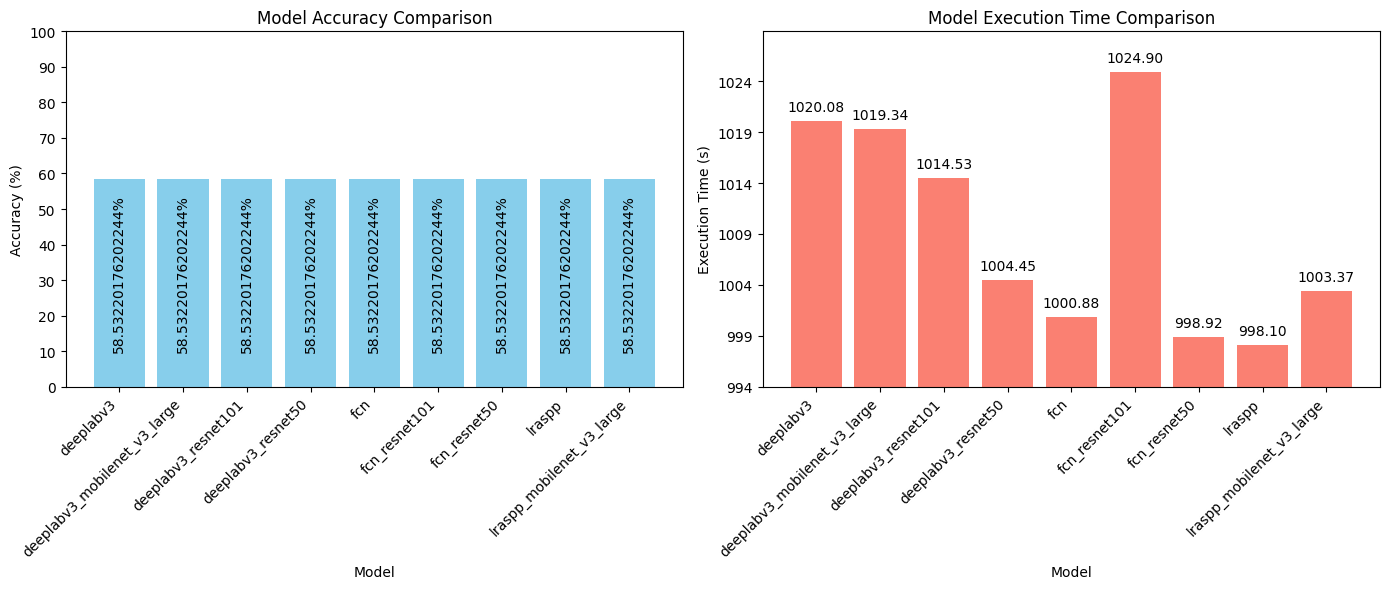

In [126]:
def plot_model_comparison(model_results):
    """
    Plots and save .png file of a comparison of model accuracies.

    Parameters:
    model_results (dict): A dictionary with model names as keys and evaluation results as values.
    """
    from statistics import mean

    df_results = pd.DataFrame({
        'Model': [model for model in available_models],
        'Accuracy (%)': [max([result[1] for result in model_results[model][0]]) for model in available_models],
        'Execution Time (s)': [model_results[model][1] for model in available_models]
    })

    plt.figure(figsize=(14, 6))

    # Plot for Accuracy
    plt.subplot(1, 2, 1)
    bars = plt.bar(df_results['Model'], df_results['Accuracy (%)'], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(range(0, 101, 10))
    for bar in bars:
        yval = bar.get_height()
        plt.annotate(f'{yval}%', xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, -125),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=90)

    # Plot for Execution Time
    plt.subplot(1, 2, 2)
    bars = plt.bar(df_results['Model'], df_results['Execution Time (s)'], color='salmon')
    plt.xlabel('Model')
    plt.ylabel('Execution Time (s)')
    plt.title('Model Execution Time Comparison')
    plt.xticks(rotation=45, ha='right')

    min_time = min(df_results['Execution Time (s)'])
    max_time = max(df_results['Execution Time (s)'])
    plt_margin = 4

    plt.ylim(min_time - plt_margin, max_time + plt_margin)
    plt.yticks(range(int(min_time - plt_margin), int(max_time + (plt_margin +1 )), 5))

    for bar in bars:
        yval = bar.get_height()
        plt.annotate(f'{yval:.2f}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()

    plt.tight_layout()


    # plt.savefig(f"{output_folder}/model_comparison.png")
    plt.show()
plot_model_comparison(model_results)

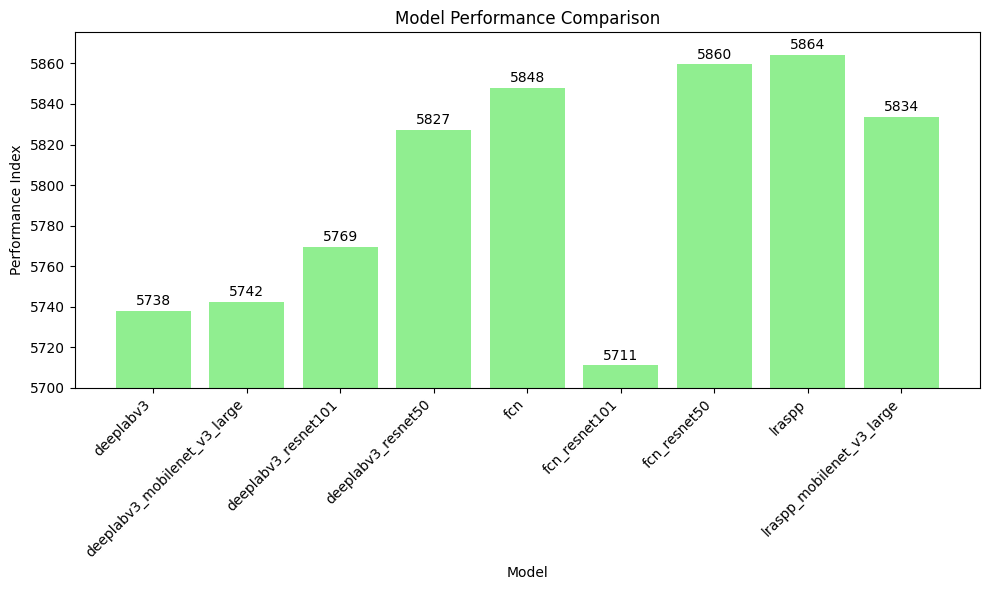

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_performance(model_results):
    """
    Plots and saves a .png file of a comparison of model performance based on accuracy and execution time.

    Parameters:
    model_results (dict): A dictionary with model names as keys and evaluation results as values.
    """
    df_results = pd.DataFrame({
        'Model': [model for model in model_results],
        'Accuracy (%)': [max([result[1] for result in model_results[model][0]]) for model in model_results],
        'Execution Time (s)': [model_results[model][1] for model in model_results]
    })

    # Calculate performance index (accuracy / execution time)
    df_results['Performance Index'] = (df_results['Accuracy (%)'] / df_results['Execution Time (s)']) * 100000
    df_results_sorted = df_results # .sort_values(by='Performance Index', ascending=False)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_results_sorted['Model'], df_results_sorted['Performance Index'], color='lightgreen')
    plt.xlabel('Model')
    plt.ylabel('Performance Index')
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45, ha='right')

    min_performance = df_results_sorted['Performance Index'].min()
    max_performance = df_results_sorted['Performance Index'].max()
    plt_margin = 11

    plt.ylim(min_performance - plt_margin, max_performance + plt_margin)
    plt.yticks(range(int(min_performance - plt_margin), int(max_performance + plt_margin) + 1, 20))


    for bar in bars:
        yval = bar.get_height()
        plt.annotate(f'{yval:.0f}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, 2),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    # plt.savefig("model_performance.png")
    plt.show()

# Example usage
plot_model_performance(model_results)
